# Figure 1 Tumor and MDSC Dynamics in Untreated B16F10 Model

## Environment

In [1]:
from scipy.integrate import odeint
from scipy.optimize import differential_evolution

In [2]:
%run 00_data_preprocessing.ipynb

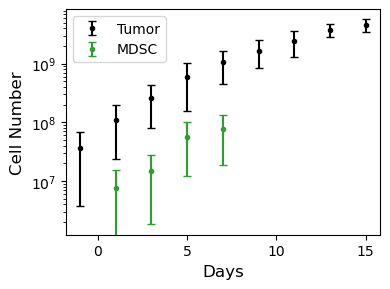

In [3]:
plt.figure(figsize=(4, 3))
plt.errorbar(unt_v_days, unt_v_data, yerr=unt_v_std, fmt='o', capsize=3, markersize=3, color='black', label='Tumor')
plt.errorbar(unt_mdsc['day'], unt_mdsc['N_mean'], yerr=unt_mdsc['N_std'], fmt='o', capsize=3, markersize=3, color='tab:green',label='MDSC')
plt.xlabel('Days', fontsize=12)
plt.ylabel('Cell Number', fontsize=12)
#plt.title('Untreated')
plt.yscale('log')
plt.legend()
plt.tight_layout()

# ODE model of B16F10 tumor
$$\frac{dV}{dt} = v_r \cdot V \cdot \log{\frac{v_k}{V}}$$

In [4]:
# Gompertz model
def gompertz_model(V, t, r, K):
    return r * V * np.log(K / V)
def gompertz_solve(t, r, K, V0):
    return odeint(gompertz_model, V0, t, args=(r, K)).ravel()

# Loss function
def loss_b16(params, model_solve, time_data, mean_volume_data, std_dev_data):
    V0 = mean_volume_data[0]
    model_pred = model_solve(time_data, *params, V0)
    return np.sum(((mean_volume_data - model_pred) / std_dev_data) ** 2)

# Parameter optimization function
def opt_params(model_solve, bounds, time_data, mean_volume_data, std_dev_data):
    result = differential_evolution(loss_b16, bounds, args=(model_solve, time_data, mean_volume_data, std_dev_data))
    return result.x

In [5]:
# parameter optimization
gompertz_bounds = [(0, 1), (1e6, 1e11)]

params_gompertz = differential_evolution(
                    loss_b16, gompertz_bounds, 
                    args=(gompertz_solve, unt_v_days, unt_v_data, unt_v_std),
                    strategy='best1bin', 
                    maxiter=1000, popsize=15, seed=12
)

print(f"Tumor param:{params_gompertz}")

Tumor param: message: Optimization terminated successfully.
 success: True
     fun: 0.07696436063030221
       x: [ 9.935e-02  1.639e+10]
     nit: 19
    nfev: 612
     jac: [ 6.285e-06 -2.418e-13]


In [6]:
v_r, v_k = params_gompertz.x
print("v_r =", v_r)
print("v_k =", v_k)

v_r = 0.09934668264267044
v_k = 16391427148.887676


## Fitting Simulation

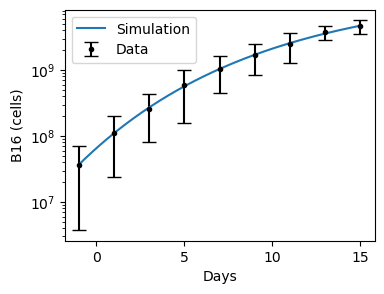

In [7]:
# Simulation
time_sim = np.arange(-1, 15.1, 0.1)
fit_gompertz = gompertz_solve(time_sim, v_r, v_k, unt_v_data[0])

# Plotting
plt.figure(figsize=(4, 3))
plt.errorbar(unt_v_days, unt_v_data, yerr=unt_v_std, fmt='o', 
             label='Data', capsize=5, markersize=3,color='black')
plt.plot(time_sim, fit_gompertz, '-', color='tab:blue', label=f'Simulation')
plt.xlabel('Days')
plt.ylabel('B16 (cells)')
plt.yscale('log')
plt.legend()
plt.show()

# ODE model of B16F10 cells and MDSC
\begin{align}
\frac{dV}{dt} &= v_r \cdot V \cdot \log\left(\frac{v_k}{V}\right) \\
\frac{dM}{dt} &= m_v \cdot V - m_d \cdot M
\end{align}

## Model construction

In [8]:
# model
def tumor_mdsc_model(y, t, v_r, v_k, m_v, m_d):
    V, M = y
    dVdt = v_r * V * np.log(v_k / V)
    dMdt = m_v * V - m_d * M
    return [dVdt, dMdt]

# loss function
def loss_b16_mdsc(params):
    m_v, m_d = params
    sol = odeint(tumor_mdsc_model, [V0, M0], t_fit, args=(v_r, v_k, m_v, m_d))
    M_sim = sol[:, 1]
    M_fit = M_sim[1:]
    residuals = (M_fit - mdsc_exp) / mdsc_std
    return np.sum(residuals**2)

In [9]:
# Initial values
V0 = unt_v_data[0]
M0 = unt_mdsc_data[0]

# Experimental data for fitting
t_fit = np.array([-1, 1, 3, 5, 7])
mdsc_exp = unt_mdsc_data[1:]
mdsc_std = unt_mdsc_std[1:]

In [10]:
bounds = [(1e-3, 1), (1e-3, 1)]

# differential evolution
params_unt_mdsc = differential_evolution(
            loss_b16_mdsc, bounds, 
            strategy='best1bin', 
            maxiter=1000, popsize=15, seed=12
)

In [11]:
m_v, m_d = params_unt_mdsc.x
print("m_v =", m_v)
print("m_d =", m_d)

m_v = 0.048708323378192864
m_d = 0.30626667060282536


## Simulation

In [12]:
dir_path = '../../results/main/01'
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

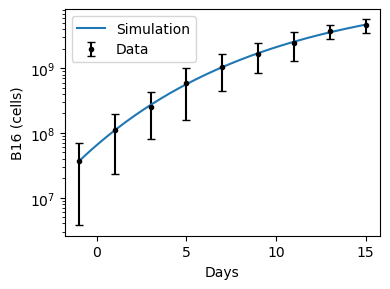

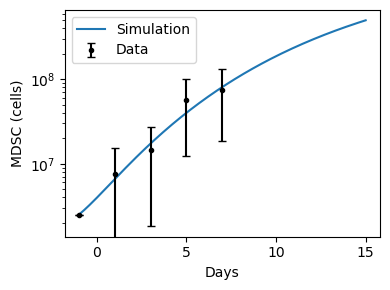

In [13]:
sol = odeint(tumor_mdsc_model, [V0, M0], time_sim, args=(v_r, v_k, m_v, m_d))
V_sol, M_sol = sol.T

# --- Figure 1A: Tumor volume ---
plt.figure(figsize=(4, 3))
plt.errorbar(unt_v_days, unt_v_data, yerr=unt_v_std, fmt='o', capsize=3, markersize=3, color='black', label='Data')
plt.plot(time_sim, V_sol, label='Simulation', color='tab:blue')
#plt.title('Untreated B16 cells')
plt.xlabel('Days')
plt.ylabel('B16 (cells)')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(dir_path, 'fig1a.pdf'), dpi=300)
plt.savefig(os.path.join(dir_path, 'fig1a.jpeg'), dpi=300)


# --- Figure 1B: MDSC ---
plt.figure(figsize=(4, 3))
plt.plot(time_sim, M_sol, label='Simulation', color='tab:blue')
plt.errorbar(unt_mdsc_days, unt_mdsc_data, yerr=unt_mdsc_std, fmt='o', capsize=3, markersize=3, color='black',label='Data')
#plt.title('Untreated MDSC cells')
plt.xlabel('Days')
plt.ylabel('MDSC (cells)')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(dir_path, 'fig1b.pdf'), dpi=300)
plt.savefig(os.path.join(dir_path, 'fig1b.jpeg'), dpi=300)